# SVM

分類のためのサポートベクターマシン（SVM、サポートベクトルマシン）のクラスをスクラッチで作成していきます。NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。


SVMには学習時に分類の間違いを認めるソフトマージンSVMと、認めないハードマージンSVMがありますが、ここでは実装が単純なハードマージンSVMを扱います。


以下に雛形を用意してあります。このScratchSVMClassifierクラスにコードを書き加えていってください。

## 【事前準備】

In [1]:
# scikit-learnの「set_config(display="diagram")」を使用するため、scikitlearnを最新verに更新
# !pip install scikit-learn==0.23.2 --target drive/My\ Drive/MyModule
# !pip install scikit-learn==0.23.2
# !pip list
## Google Drive上にインストールしたモジュールのインポート##
import sys
sys.path.append('/content/drive/My Drive/MyModule')

In [2]:
## モジュールのインポート ##
# 一般
import random
import math
# データ分析
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style
%matplotlib inline
matplotlib.style.use('ggplot')
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
# scikit-learn
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
# その他
from google.colab import drive #GoogleDriveモジュール
# drive.mount('/content/drive') #GoogleDriveのマウント

## 【実装】

### ●ScratchSVMClassifierクラスの定義

In [3]:
class ScratchSVMClassifier():
    """
    SVM分類器のスクラッチ実装
    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    kernel : str
      カーネルの種類。線形カーネル（linear）か多項式カーネル（polly）
    threshold : float
      サポートベクターを選ぶための閾値
    verbose : bool
      学習過程を出力する場合はTrue
    gamma : float
      カーネル関数のガンマ係数
    coef0 : float
      カーネル関数の係数Θ0
    degree : int
      カーネル関数の次数
    Attributes
    ----------
    self.n_support_vectors : int
      サポートベクターの数
    self.index_support_vectors : 次の形のndarray, shape (n_support_vectors,)
      サポートベクターのインデックス
    self.lam_sv :  次の形のndarray, shape(n_support_vectors, 1)
      サポートベクターの未定乗数
    self.X_sv :  次の形のndarray, shape(n_support_vectors, n_features)
      サポートベクターの特徴量
    self.y_sv :  次の形のndarray, shape(n_support_vectors, 1)
      サポートベクターのラベル
    self.label :  次の形のndarray, shape (2,)
      fitメソッドにて学習した2値の正解ラベル
    self.lam_log :  次の形のndarray, shape(self.iter, 1)
      ラグランジュ未定乗数の更新ログ
    """
    def __init__(self, num_iter, lr, kernel='linear', threshold=1e-5, verbose=False, gamma=1, coef0=0, degree=1):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        self.lr = lr
        self.kernel = kernel
        self.threshold = threshold
        self.verbose = verbose
        self.label = np.zeros(2)
        self.lam_log = np.array([])
        self.gamma = gamma
        self.coef0 = coef0
        self.degree = degree
    def fit(self, X, y, X_val=None, y_val=None):
        """
        SVM分類器を学習する。検証データが入力された場合はそれに対する精度もイテレーションごとに計算する。
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """

        # 正解ラベルyをインスタンス変数に保持（正解ラベルが2値以外の場合は強制終了）
        self.label = np.unique(y)
        if (len(self.label) != 2):
            print("Warning: 正解ラベルが2値ではありません。学習を中断します。")
            return
        # 正解ラベルyの2値を-1と1に変換
        y_transformed = np.where(y == np.max(self.label), 1, -1)

        if ((X_val is not None) and (y_val is not None)):
            # 検証データが与えられた場合は検証データも上記の変換処理を実施
            y_val_transformed = np.where(y_val == np.max(self.label), 1, -1)  # 正解ラベルyの2値を-1と1に変換
        else:
            # 検証データがない場合はNoneをセット
            y_val_transformed = None

        # 最急降下法によりラグランジュ未定乗数を更新
            self._gradient_descent(X, y_transformed)

    def predict(self, X):
        """
        SVM分類器を使いラベルを推定する。
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル
        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            SVM分類器による推定結果
        """
        n_samples = X.shape[0]    # サンプル数
        n_features = X.shape[1]    # 特徴量の数
        ret_y_pred = np.zeros(n_samples)    # 目的変数の推定値

        # 各サンプル数について下記の数式を演算
        for i in range(n_samples):
            # f(x)=Σλn*y_sv_n*k(x,sn)
            for n in range(self.n_support_vectors):
                  ret_y_pred[i] += self.lam_sv[n] * self.y_sv[n] * self._kernel_func(X[i, :], self.X_sv[n, :])

        # 確率が閾値以上の場合は正解ラベルの大きい方の値を、閾値未満の場合は小さい方の値を推定値として出力
        ret_y_pred = np.where(ret_y_pred >= 0, np.max(self.label), np.min(self.label))

        return  ret_y_pred

    def _gradient_descent(self, X, y, X_val=None, y_val=None):
        """
        最急降下法によりラグランジュ未定乗数を計算する
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples + 1, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples + 1, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        Returns
        -------
        None
        """
        n_samples = X.shape[0]    # サンプル数
        n_features = X.shape[1]    # 特徴量の数

        # ラグランジュ未定乗数の変数をサンプル数（=Xの行数）だけ用意
        temp_lam = np.zeros(n_samples)
        self.lam_log = np.zeros((1, n_samples))

        self.n_support_vectors = 0
        self.index_support_vectors = np.array([])
        self.lam_sv = np.array([[]])
        self.X_sv = np.array([[]])
        self.y_sv = np.array([[]])

        # イテレーション数だけラグランジュ未定乗数を更新する
        for k in range(self.iter):
            # デバッグ情報出力
            print("            イテレーション:{}回目".format(k))
            # 各サンプルデータのラグランジュ未定乗数を更新
            for i in range(n_samples):
                value = 0
                # 「Σλj*yi*yj*k(xi, xj)」を計算
                for j in range(n_samples):
                    kernel = self._kernel_func(X[i, :], X[j, :])
                    value += temp_lam[j] * y[i] * y[j] * kernel
                # 「λnew=λold+α(1-Σλj*yi*yj*k(xi, xj))」からλnewを算出
                temp_lam[i] = temp_lam[i] + self.lr * (1 - value)

                # λnewが0未満の場合はλnew=0に変更
                if (temp_lam[i] < 0):
                    temp_lam[i] = 0
            # ラグランジュ未定乗数を更新ログに追加
            self.lam_log = np.append(self.lam_log, temp_lam.reshape(1,n_samples), axis=0)
            # デバッグ情報出力
            if self.verbose:
                print("            temp_lam:\n{}".format(temp_lam))
                print("            len(temp_lam):\n{}".format(len(temp_lam)))
        
        # 閾値よりも大きい未定乗数のサンプルをサポートベクターとして選定
        for i in range(n_samples):
            if (temp_lam[i] > self.threshold):
                self.n_support_vectors += 1   # サポートベクターのカウンタをインクリメント
                self.index_support_vectors =  np.append(self.index_support_vectors, i)  # サポートベクターの特徴量のインデックスを記録
                self.lam_sv = np.append(self.lam_sv, temp_lam[i])   # サポートベクターのラグランジュ未定乗数を記録
                self.X_sv = np.append(self.X_sv, X[i, :])   # サポートベクターの特徴量ベクトル（1 x n_features）を記録
                self.y_sv = np.append(self.y_sv, y[i])   # サポートベクターの正解ラベルを記録
        # サポートベクターの特徴量ベクトルの配列を、サポートベクター数 x 特徴量数にreshape
        self.X_sv = self.X_sv.reshape(self.n_support_vectors, n_features)
        return

    def _kernel_func(self, a, b):
        """
        線形カーネル関数
        Parameters
        ----------
        a : 次の形のndarray, shape (n_features, 1)
            特徴量ベクトル
        b : 次の形のndarray, shape (n_features, 1)
            特徴量ベクトル
        Returns
        -------
        ret_kernel : float
            特徴量ベクトルaとbに対する線形カーネル（a.T・b）の演算結果
        """
        # 線形カーネル
        if (self.kernel == "linear"):
            ret_kernel = a.T @ b
        # 多項式カーネル
        elif (self.kernel == "poly"):
            ret_kernel = ((self.gamma * a.T @ b) + self.coef0)**self.degree
        return ret_kernel

        
        

### ●推定器の評価指標を記録するスコアボードのクラス

In [4]:
## 推定器の指標値を記録するスコアボードのクラス ##
class ScoreBoard():
    def __init__(self, name1=None, name2=None):
        self.df_score = pd.DataFrame([])   #各指標値を記録するDataFrame
        if (name1 is None):   name1 = ""
        if (name2 is None):   name2 = ""
        self.name1 = name1
        self.name2 = name2
        print("{}スコアボード{}が生成されました。".format(self.name1, self.name2))
    def calcurate_scores(self, arg_y_true, arg_y_predict, arg_y_predict_proba=None, arg_columns=None):
        # Accuracy（正解率）
        accuracy = accuracy_score(arg_y_true, arg_y_predict)

        #Precision（適合率）
        precision = precision_score(arg_y_true, arg_y_predict)

        #Recall（再現率）
        recall = recall_score(arg_y_true, arg_y_predict)

        #F値
        f1 = f1_score(arg_y_true, arg_y_predict)

        #AUC
        if (arg_y_predict_proba is not None):
            roc_auc = roc_auc_score(arg_y_true, arg_y_predict_proba)
            score_list = [accuracy, precision, recall, f1, roc_auc]
            index_list = ["Accuacy", "Precision", "Recall", "F1", "ROC_AUC"]
        else:
            score_list = [accuracy, precision, recall, f1]
            index_list = ["Accuacy", "Precision", "Recall", "F1"]

        #Confusion matrix（混同行列）
        print("\n")
        print("###Confusion matrix（混同行列）###")
        print(confusion_matrix(arg_y_true, arg_y_predict))

        #指標値の比較用テーブルに登録
        # if(self.df_score.empty):
        #     self.df_score = pd.DataFrame([accuracy, precision, recall, f1, roc_auc], index=["Accuacy", "Precision", "Recall", "F1", "ROC_AUC"], columns=arg_columns)
        # else:
        df_score_temp = pd.DataFrame(data=score_list, index=index_list, columns=arg_columns)
        self.df_score = pd.concat([self.df_score, df_score_temp], axis=1)
        print("\n")
        print("{}スコアボード{}:".format(self.name1, self.name2))
        display(self.df_score)

        # #ROC曲線、AUC
        # #y_testの値を2→1, 1→0に変換
        # y_test1_dummy = np.where(y_test1==1, 0, 1)
        # fpr, tpr, thresholds = metrics.roc_curve(y_test1_dummy, y_predict_proba[:, -1]) # FPR（偽陽性率）、TPR（真陽性率）、閾値を算出
        # auc = metrics.auc(fpr, tpr)  # AUCを算出
        # plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
        # plt.legend()
        # plt.title('ROC curve')
        # plt.xlabel('False Positive Rate')
        # plt.ylabel('True Positive Rate')
        # plt.grid(True)

        # 決定領域を描画
        # decision_region(X_train_transformed, y_train, model=clf, step=0.01, title='decision region', xlabel=df3.columns[0], ylabel=df3.columns[1], target_names=df3.iloc[:, -1].unique())
        
        return

# スコアボードをインスタンス化
score_board1 = ScoreBoard(name2 = "1")
score_board2 = ScoreBoard(name2 = "2")

スコアボード1が生成されました。
スコアボード2が生成されました。


### ●データセットの準備（シンプルデータセット1）

In [5]:
## シンプルデータセット1 ##
np.random.seed(seed=0)
n_samples = 500
f0 = [-1, 2]
f1 = [2, -1]
cov = [[1.0,0.8], [0.8, 1.0]]
f0 = np.random.multivariate_normal(f0, cov, n_samples // 2)
f1 = np.random.multivariate_normal(f1, cov, n_samples // 2)
X = np.concatenate([f0, f1])
y = np.concatenate([
    np.full(n_samples // 2, 1),
    np.full(n_samples // 2, -1)
])

df_X = pd.DataFrame(data=X, columns=["X0", "X1"])
df_y = pd.DataFrame(data=y, columns=["y"])
df_simple1 = pd.concat([df_X, df_y], axis=1)

print("df_simple1:")
display(df_simple1)

#データセットを学習用と検証用に分割
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, train_size = 0.75, random_state=0)

df_simple1:


,X0,X1,y
0,-2.800068,0.453014,1
1,-2.637145,1.780120,1
2,-2.462679,-0.080763,1
3,-1.853470,1.050804,1
4,-1.031921,2.227765,1
...,...,...,...
495,1.525060,-1.361861,-1
496,2.682255,-0.165458,-1
497,1.595155,-1.143723,-1
498,2.158431,-0.781996,-1


,X0,X1,y
X0,1.000000,-0.471745,-0.842276
X1,-0.471745,1.000000,0.836915
y,-0.842276,0.836915,1.000000


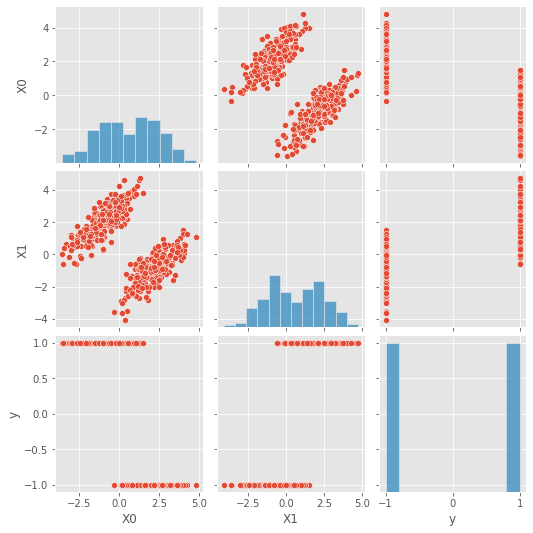

In [6]:
#相関係数
display(df_simple1.corr())

#散布図行列を作成
import seaborn as sns
sns.pairplot(df_simple1, diag_kind="hist");

### ●【動作確認】ScratchSVMClassifierクラスを用いた分類（イテレーション:1）

In [7]:
# 標準化処理とSVMをパイプラインに組み込み
pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),      #変換器
    ("classifier", ScratchSVMClassifier(num_iter=1, lr=0.2,  kernel='linear', threshold=1e-5, verbose=False)) #推定器
])

# データセットに対して学習・推定・評価
X = X_train1
Xt = X_test1
y = y_train1
yt = y_test1
pipeline.fit(X, y)
y_predict = pipeline.predict(Xt)
# y_predict_proba = pipeline.predict_proba(Xt)

np.set_printoptions(threshold=100000)    #ndarrayの要素の表示数上限を設定
print("y_true:")
print(yt)
print("y_predict:")
print(y_predict)
# print("y_predict_proba:")
# print(y_predict_proba)

# 推定器のスコアを計算し、スコアボードに記録
score_board1.calcurate_scores(yt, y_predict, arg_columns=["SVM(iter:1)"])

#モデルのインスタンスを複製
pipeline1 = pipeline

            イテレーション:0回目
y_true:
[ 1 -1 -1 -1 -1  1 -1 -1  1  1  1 -1 -1 -1  1 -1 -1 -1  1  1  1 -1  1  1
  1 -1  1 -1  1  1 -1  1  1  1 -1 -1 -1 -1 -1  1 -1  1 -1  1  1  1  1 -1
 -1  1 -1  1 -1  1  1  1 -1  1  1 -1  1 -1 -1 -1 -1  1  1 -1 -1  1  1  1
 -1 -1  1 -1 -1  1 -1 -1 -1  1 -1  1 -1 -1 -1  1 -1  1  1 -1 -1  1  1 -1
  1 -1  1  1  1 -1  1 -1  1 -1  1  1 -1  1 -1  1  1  1 -1 -1 -1 -1  1  1
 -1  1  1 -1 -1]
y_predict:
[ 1 -1 -1 -1 -1  1 -1 -1  1  1  1 -1 -1 -1  1 -1 -1 -1  1  1  1 -1  1  1
  1 -1  1 -1  1  1 -1  1  1  1 -1 -1 -1 -1 -1  1 -1  1 -1  1  1  1  1 -1
 -1  1 -1  1 -1  1  1  1 -1  1  1 -1  1 -1 -1 -1 -1  1  1 -1 -1  1  1  1
 -1 -1  1 -1 -1  1 -1 -1 -1  1 -1  1 -1 -1 -1  1 -1  1  1 -1 -1  1  1 -1
  1 -1  1  1  1 -1  1 -1  1 -1  1  1 -1  1 -1  1  1  1 -1 -1 -1 -1  1  1
 -1  1  1 -1 -1]


###Confusion matrix（混同行列）###
[[63  0]
 [ 0 62]]


スコアボード1:


,SVM(iter:1)
Accuacy,1.0
Precision,1.0
Recall,1.0
F1,1.0


In [8]:
print(pipeline["classifier"].n_support_vectors)
print(pipeline["classifier"].index_support_vectors)
print(pipeline["classifier"].lam_sv)
print(pipeline["classifier"].X_sv)
print(pipeline["classifier"].y_sv)

36
[  0.   1.   2.   3.   4.   5.   6.   7.   9.  10.  12.  17.  18.  23.
  27.  29.  32.  44.  51.  54.  60.  72.  80.  90.  94. 119. 161. 175.
 181. 183. 189. 192. 221. 278. 290. 363.]
[0.2        0.10998071 0.12395872 0.03600559 0.01690227 0.06416551
 0.02722982 0.0453345  0.0241095  0.00693492 0.01637146 0.05022426
 0.04859289 0.00810833 0.10137772 0.05257754 0.04517574 0.09819779
 0.01364611 0.02907269 0.06208142 0.0087032  0.00388158 0.00968272
 0.00493932 0.01981257 0.01620933 0.00912958 0.04481547 0.00030491
 0.02770446 0.02961853 0.01794175 0.03922426 0.03241757 0.05786454]
[[-1.53501393  0.30223187]
 [-1.33835957  0.64877879]
 [ 0.39943667 -1.50822722]
 [ 0.73090069 -1.41740983]
 [ 1.36424609 -0.52029715]
 [ 0.99476022 -0.34070149]
 [-0.94813601  0.69654981]
 [ 0.56540711 -0.97736716]
 [ 0.85405674 -0.66555025]
 [ 0.65351915 -1.07359897]
 [ 1.29528858 -0.04079473]
 [-0.07576128  1.42397587]
 [-0.37430717  0.87253485]
 [-0.24640586  1.29268034]
 [-0.57452655  0.11223133]
 [-0.

### ●【動作確認】ScratchSVMClassifierクラスを用いた分類（イテレーション:10）

In [9]:
# 標準化処理とSVMをパイプラインに組み込み
pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),      #変換器
    ("classifier", ScratchSVMClassifier(num_iter=10, lr=0.2,  kernel='linear', threshold=1e-5, verbose=False)) #推定器
])

# データセットに対して学習・推定・評価
X = X_train1
Xt = X_test1
y = y_train1
yt = y_test1
pipeline.fit(X, y)
y_predict = pipeline.predict(Xt)
# y_predict_proba = pipeline.predict_proba(Xt)

np.set_printoptions(threshold=100000)    #ndarrayの要素の表示数上限を設定
print("y_true:")
print(yt)
print("y_predict:")
print(y_predict)
# print("y_predict_proba:")
# print(y_predict_proba)

# 推定器のスコアを計算し、スコアボードに記録
score_board1.calcurate_scores(yt, y_predict, arg_columns=["SVM(iter:10)"])

#モデルのインスタンスを複製
pipeline10 = pipeline

            イテレーション:0回目
            イテレーション:1回目
            イテレーション:2回目
            イテレーション:3回目
            イテレーション:4回目
            イテレーション:5回目
            イテレーション:6回目
            イテレーション:7回目
            イテレーション:8回目
            イテレーション:9回目
y_true:
[ 1 -1 -1 -1 -1  1 -1 -1  1  1  1 -1 -1 -1  1 -1 -1 -1  1  1  1 -1  1  1
  1 -1  1 -1  1  1 -1  1  1  1 -1 -1 -1 -1 -1  1 -1  1 -1  1  1  1  1 -1
 -1  1 -1  1 -1  1  1  1 -1  1  1 -1  1 -1 -1 -1 -1  1  1 -1 -1  1  1  1
 -1 -1  1 -1 -1  1 -1 -1 -1  1 -1  1 -1 -1 -1  1 -1  1  1 -1 -1  1  1 -1
  1 -1  1  1  1 -1  1 -1  1 -1  1  1 -1  1 -1  1  1  1 -1 -1 -1 -1  1  1
 -1  1  1 -1 -1]
y_predict:
[ 1 -1 -1 -1 -1  1 -1 -1  1  1  1 -1 -1 -1  1 -1 -1 -1  1  1  1 -1  1  1
  1 -1  1 -1  1  1 -1  1  1  1 -1 -1 -1 -1 -1  1 -1  1 -1  1  1  1  1 -1
 -1  1 -1  1 -1  1  1  1 -1  1  1 -1  1 -1 -1 -1 -1  1  1 -1 -1  1  1  1
 -1 -1  1 -1 -1  1 -1 -1 -1  1 -1  1 -1 -1 -1  1 -1  1  1 -1 -1  1  1 -1
  1 -1  1  1  1 -1  1 -1  1 -1  1  1 -1  1 -1  1  1  1 -1 -1 -1 -1 

,SVM(iter:1),SVM(iter:10)
Accuacy,1.0,1.0
Precision,1.0,1.0
Recall,1.0,1.0
F1,1.0,1.0


In [10]:
pd.DataFrame(data=pipeline["classifier"].lam_log)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374
0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.20000,0.109981,0.123959,0.036006,0.016902,0.064166,0.027230,0.045335,0.0,0.024110,0.006935,0.0,0.016371,0.0,0.0,0.0,0.0,0.050224,0.048593,0.0,0.0,0.0,0.0,0.008108,0.0,0.0,0.0,0.101378,0.0,0.052578,0.0,0.0,0.045176,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.057865,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.02701,0.000000,0.020576,0.000000,0.002175,0.117040,0.027732,0.053507,0.0,0.037493,0.000000,0.0,0.058524,0.0,0.0,0.0,0.0,0.052894,0.084821,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.210772,0.0,0.101578,0.0,0.0,0.075577,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.122128,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.00000,0.000000,0.000000,0.000000,0.000000,0.065322,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.044095,0.0,0.0,0.0,0.0,0.004603,0.093617,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.303595,0.0,0.129933,0.0,0.0,0.089405,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.181029,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.058774,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.380841,0.0,0.129262,0.0,0.0,0.071491,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.238266,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.003259,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.442519,0.0,0.113743,0.0,0.0,0.045646,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.288973,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.497039,0.0,0.088068,0.0,0.0,0.010562,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.332908,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.546878,0.0,0.057500,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.373882,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.594043,0.0,0.022266,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.413401,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [11]:
print(pipeline["classifier"].n_support_vectors)
print(pipeline["classifier"].index_support_vectors)
print(pipeline["classifier"].lam_sv)
print(pipeline["classifier"].X_sv)
print(pipeline["classifier"].y_sv)

9
[ 27.  44.  60. 181. 189. 192. 278. 290. 363.]
[0.68161913 0.67046424 0.33356221 0.22616692 0.05605295 0.1154382
 0.25133976 0.18400076 0.47801834]
[[-0.57452655  0.11223133]
 [ 0.07821023 -0.62688552]
 [ 0.41776472 -0.4206833 ]
 [-0.21678734  0.67080275]
 [-0.03442764  0.93073002]
 [ 0.31864418 -0.60723732]
 [ 0.38228512 -0.47061822]
 [-0.12065046  0.75917477]
 [-0.83987192 -0.11185208]]
[ 1. -1. -1.  1.  1. -1. -1.  1.  1.]


### ●【動作確認】ScratchSVMClassifierクラスを用いた分類（イテレーション:100）

In [12]:
# 標準化処理とSVMをパイプラインに組み込み
pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),      #変換器
    ("classifier", ScratchSVMClassifier(num_iter=100, lr=0.2,  kernel='linear', threshold=1e-5, verbose=False)) #推定器
])

# データセットに対して学習・推定・評価
X = X_train1
Xt = X_test1
y = y_train1
yt = y_test1
pipeline.fit(X, y)
y_predict = pipeline.predict(Xt)
# y_predict_proba = pipeline.predict_proba(Xt)

np.set_printoptions(threshold=100000)    #ndarrayの要素の表示数上限を設定
print("y_true:")
print(yt)
print("y_predict:")
print(y_predict)
# print("y_predict_proba:")
# print(y_predict_proba)

# 推定器のスコアを計算し、スコアボードに記録
score_board1.calcurate_scores(yt, y_predict, arg_columns=["SVM(iter:100)"])

#モデルのインスタンスを複製
pipeline100 = pipeline

            イテレーション:0回目
            イテレーション:1回目
            イテレーション:2回目
            イテレーション:3回目
            イテレーション:4回目
            イテレーション:5回目
            イテレーション:6回目
            イテレーション:7回目
            イテレーション:8回目
            イテレーション:9回目
            イテレーション:10回目
            イテレーション:11回目
            イテレーション:12回目
            イテレーション:13回目
            イテレーション:14回目
            イテレーション:15回目
            イテレーション:16回目
            イテレーション:17回目
            イテレーション:18回目
            イテレーション:19回目
            イテレーション:20回目
            イテレーション:21回目
            イテレーション:22回目
            イテレーション:23回目
            イテレーション:24回目
            イテレーション:25回目
            イテレーション:26回目
            イテレーション:27回目
            イテレーション:28回目
            イテレーション:29回目
            イテレーション:30回目
            イテレーション:31回目
            イテレーション:32回目
            イテレーション:33回目
            イテレーション:34回目
            イテレーション:35回目
            イテレーション:36回目
            イテレーション:37回目
            イテレーション:38回目
            イテレーション:39回目
          

,SVM(iter:1),SVM(iter:10),SVM(iter:100)
Accuacy,1.0,1.0,1.0
Precision,1.0,1.0,1.0
Recall,1.0,1.0,1.0
F1,1.0,1.0,1.0


In [13]:
print(pipeline["classifier"].n_support_vectors)
print(pipeline["classifier"].index_support_vectors)
print(pipeline["classifier"].lam_sv)
print(pipeline["classifier"].X_sv)
print(pipeline["classifier"].y_sv)

3
[ 27.  44. 363.]
[1.82074303 2.00254888 0.23917577]
[[-0.57452655  0.11223133]
 [ 0.07821023 -0.62688552]
 [-0.83987192 -0.11185208]]
[ 1. -1.  1.]


### ●【比較用】scikit-learnのSVCクラスを用いた分類（線形カーネル）

In [14]:
# 標準化処理とSVMをパイプラインに組み込み
pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),      #変換器
    ("classifier", SVC(kernel="linear", C=1, random_state=0, gamma="scale", probability=True)) #推定器
])

# データセットに対して学習・推定・評価
X = X_train1
Xt = X_test1
y = y_train1
yt = y_test1
pipeline.fit(X, y)
y_predict = pipeline.predict(Xt)
# y_predict_proba = pipeline.predict_proba(Xt)

np.set_printoptions(threshold=100000)    #ndarrayの要素の表示数上限を設定
print("y_true:")
print(yt)
print("y_predict:")
print(y_predict)
# print("y_predict_proba:")
# print(y_predict_proba)

# 推定器のスコアを計算し、スコアボードに記録
score_board1.calcurate_scores(yt, y_predict, arg_columns=["SVM(sklearn)"])

#モデルのインスタンスを複製
pipeline_sklearn = pipeline

y_true:
[ 1 -1 -1 -1 -1  1 -1 -1  1  1  1 -1 -1 -1  1 -1 -1 -1  1  1  1 -1  1  1
  1 -1  1 -1  1  1 -1  1  1  1 -1 -1 -1 -1 -1  1 -1  1 -1  1  1  1  1 -1
 -1  1 -1  1 -1  1  1  1 -1  1  1 -1  1 -1 -1 -1 -1  1  1 -1 -1  1  1  1
 -1 -1  1 -1 -1  1 -1 -1 -1  1 -1  1 -1 -1 -1  1 -1  1  1 -1 -1  1  1 -1
  1 -1  1  1  1 -1  1 -1  1 -1  1  1 -1  1 -1  1  1  1 -1 -1 -1 -1  1  1
 -1  1  1 -1 -1]
y_predict:
[ 1 -1 -1 -1 -1  1 -1 -1  1  1  1 -1 -1 -1  1 -1 -1 -1  1  1  1 -1  1  1
  1 -1  1 -1  1  1 -1  1  1  1 -1 -1 -1 -1 -1  1 -1  1 -1  1  1  1  1 -1
 -1  1 -1  1 -1  1  1  1 -1  1  1 -1  1 -1 -1 -1 -1  1  1 -1 -1  1  1  1
 -1 -1  1 -1 -1  1 -1 -1 -1  1 -1  1 -1 -1 -1  1 -1  1  1 -1 -1  1  1 -1
  1 -1  1  1  1 -1  1 -1  1 -1  1  1 -1  1 -1  1  1  1 -1 -1 -1 -1  1  1
 -1  1  1 -1 -1]


###Confusion matrix（混同行列）###
[[63  0]
 [ 0 62]]


スコアボード1:


,SVM(iter:1),SVM(iter:10),SVM(iter:100),SVM(sklearn)
Accuacy,1.0,1.0,1.0,1.0
Precision,1.0,1.0,1.0,1.0
Recall,1.0,1.0,1.0,1.0
F1,1.0,1.0,1.0,1.0


## 【問題1】ラグランジュの未定乗数法による最急降下
SVMの学習は、ラグランジュの未定乗数法を用います。サンプル数分のラグランジュ乗数 
λ
 を用意して、以下の式により更新していきます。この計算を行うメソッドをScratchSVMClassifierクラスに実装してください。

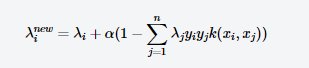

ここで 



 はカーネル関数です。線形カーネルの場合は次のようになります。他のカーネル関数にも対応できるように、この部分は独立したメソッドとしておきましょう。


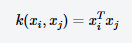



条件として、更新毎に $\lambda_{i} >= 0$を満たす必要があります。満たさない場合は$\lambda_{i} = 0$とします。


i
,
j
 : サンプルのインデックス


λ
n
e
w
i
 : 更新後のi番目のサンプルのラグランジュ乗数


λ
i
 : 更新前のi番目のサンプルのラグランジュ乗数


α
 : 学習率


λ
j
 : j番目のサンプルのラグランジュ乗数


y
i
 : i番目のサンプルのラベル


y
j
 : j番目のサンプルのラベル


x
i
 : i番目のサンプルの特徴量ベクトル


x
j
 : j番目のサンプルの特徴量ベクトル


あるサンプルに対してのすべてのサンプルとの関係を計算していくことになります。

### 【問題1 解答】
_gradient_descentメソッドを実装し、その中にラグランジュ未定乗数λの更新処理を実装した。

## 【問題2】サポートベクターの決定
計算したラグランジュ乗数 
λ
 が設定した閾値より大きいサンプルをサポートベクターとして扱います。推定時にサポートベクターが必要になります。サポートベクターを決定し、インスタンス変数として保持しておくコードを書いてください。


閾値はハイパーパラメータですが、1e-5程度からはじめると良いでしょう。サポートベクターの数を出力させられるようにしておくと学習がうまく行えているかを確認できます。

### 【問題2 解答】
サポートベクターを決定し、インスタンス変数に保存する処理を_gradient_descentメソッド内に実装した。

## 【問題3】推定
推定時には、推定したいデータの特徴量とサポートベクターの特徴量をカーネル関数によって計算します。求めた 
f
(
x
)
 の符号が分類結果です。


 x
 : 推定したいデータの特徴量ベクトル


N
 : サポートベクターの数


n
 : サポートベクターのインデックス


λ
n
 : 
n
番目のサポートベクターのラグランジュ乗数


y
s
v
n
 : 
n
番目のサポートベクターのラベル


k
(
)
 : カーネル関数


s
n
 : 
n
番目のサポートベクターの特徴量

### 【問題3 解答】
推定処理をpredictメソッド内に実装した。

## 【問題4】学習と推定
機械学習スクラッチ入門のSprintで用意したシンプルデータセット1の2値分類に対してスクラッチ実装の学習と推定を行なってください。


scikit-learnによる実装と比べ、正しく動いているかを確認してください。


AccuracyやPrecision、Recallなどの指標値はscikit-learnを使用してください。

In [15]:
score_board1.df_score

,SVM(iter:1),SVM(iter:10),SVM(iter:100),SVM(sklearn)
Accuacy,1.0,1.0,1.0,1.0
Precision,1.0,1.0,1.0,1.0
Recall,1.0,1.0,1.0,1.0
F1,1.0,1.0,1.0,1.0


### 【問題4 解答】
FPやFNを発生させることなく分類が行えていることが確認できた。（scikit learnのSVCクラスとの推定精度の差異も無し）

## 【問題5】決定領域の可視化
決定領域を可視化してください。


以下の例のようにサポートベクターは異なる色で示してください。



In [16]:
def decision_region(X, y, model, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['0', '1'], X1=None, y1=None, target_name1=None):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は訓練データまたは検証データである。
    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2
    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)
    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(np.unique(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    if ((X1 is not None) and (y1 is not None)):
        plt.scatter(X1[:, 0], X1[:, 1], s=80, color="yellow", label=target_name1, marker='o')
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

### ●イテレーション数=1の場合

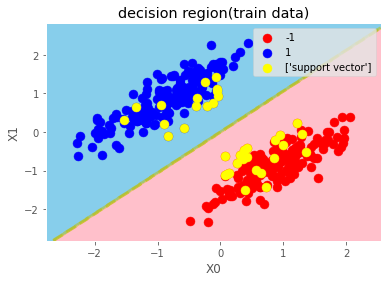

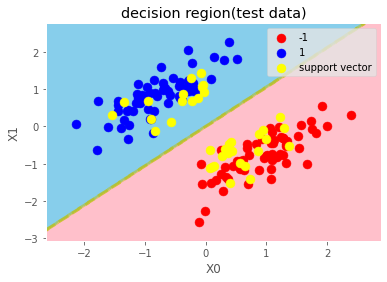

In [17]:
# 決定領域を描画（学習データ）
X_sv = pipeline1["classifier"].X_sv
y_sv = pipeline1["classifier"].y_sv
X_transformed = pipeline1["scaler"].transform(X)
decision_region(X_transformed, y, model=pipeline1["classifier"], step=0.01, title='decision region(train data)', xlabel=df_X.columns[0], ylabel=df_X.columns[1], target_names=[-1, 1], X1=X_sv, y1=y_sv, target_name1=["support vector"])
# 決定領域を描画（検証データ）
Xt_transformed = pipeline1["scaler"].transform(Xt)
decision_region(Xt_transformed, yt, model=pipeline1["classifier"], step=0.01, title='decision region(test data)', xlabel=df_X.columns[0], ylabel=df_X.columns[1], target_names=[-1,1], X1=X_sv, y1=y_sv, target_name1="support vector")

### ●イテレーション数=10の場合

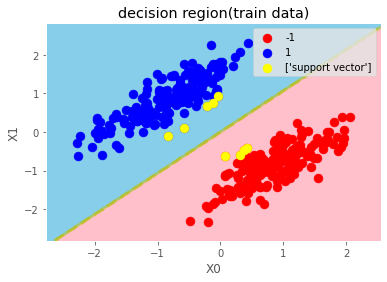

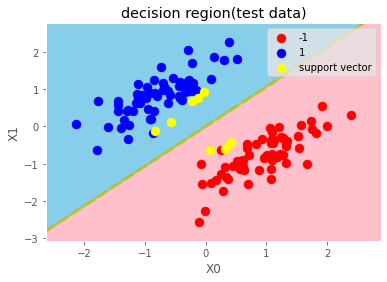

In [18]:
# 決定領域を描画（学習データ）
X_sv = pipeline10["classifier"].X_sv
y_sv = pipeline10["classifier"].y_sv
X_transformed = pipeline10["scaler"].transform(X)
decision_region(X_transformed, y, model=pipeline10["classifier"], step=0.01, title='decision region(train data)', xlabel=df_X.columns[0], ylabel=df_X.columns[1], target_names=[-1, 1], X1=X_sv, y1=y_sv, target_name1=["support vector"])
# 決定領域を描画（検証データ）
Xt_transformed = pipeline10["scaler"].transform(Xt)
decision_region(Xt_transformed, yt, model=pipeline10["classifier"], step=0.01, title='decision region(test data)', xlabel=df_X.columns[0], ylabel=df_X.columns[1], target_names=[-1,1], X1=X_sv, y1=y_sv, target_name1="support vector")

### ●イテレーション数=100の場合

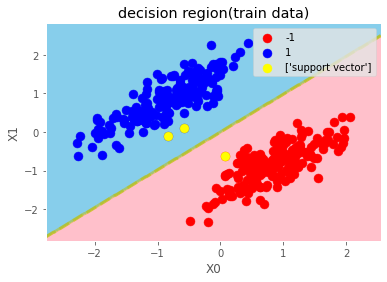

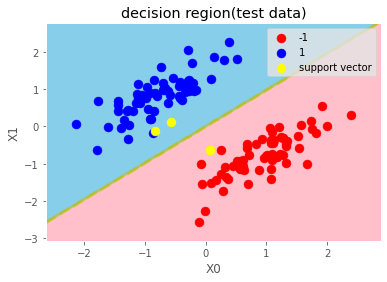

In [19]:
# 決定領域を描画（学習データ）
X_sv = pipeline100["classifier"].X_sv
y_sv = pipeline100["classifier"].y_sv
X_transformed = pipeline100["scaler"].transform(X)
decision_region(X_transformed, y, model=pipeline100["classifier"], step=0.01, title='decision region(train data)', xlabel=df_X.columns[0], ylabel=df_X.columns[1], target_names=[-1, 1], X1=X_sv, y1=y_sv, target_name1=["support vector"])
# 決定領域を描画（検証データ）
Xt_transformed = pipeline100["scaler"].transform(Xt)
decision_region(Xt_transformed, yt, model=pipeline100["classifier"], step=0.01, title='decision region(test data)', xlabel=df_X.columns[0], ylabel=df_X.columns[1], target_names=[-1,1], X1=X_sv, y1=y_sv, target_name1="support vector")

### ●scikit-learnのSVCクラス（線形カーネル）の場合

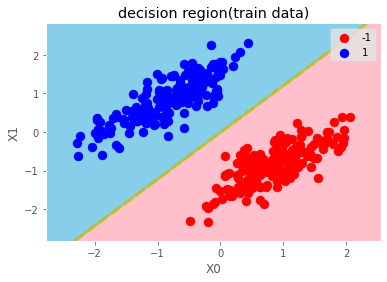

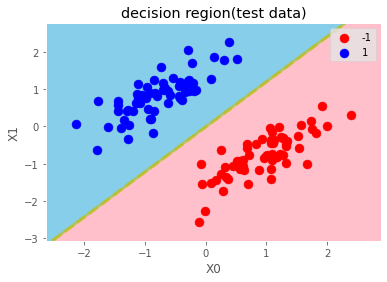

In [20]:
# 決定領域を描画（学習データ）
X_transformed = pipeline_sklearn["scaler"].transform(X)
decision_region(X_transformed, y, model=pipeline_sklearn["classifier"], step=0.01, title='decision region(train data)', xlabel=df_X.columns[0], ylabel=df_X.columns[1], target_names=[-1, 1])
# 決定領域を描画（検証データ）
Xt_transformed = pipeline_sklearn["scaler"].transform(Xt)
decision_region(Xt_transformed, yt, model=pipeline_sklearn["classifier"], step=0.01, title='decision region(test data)', xlabel=df_X.columns[0], ylabel=df_X.columns[1], target_names=[-1,1])

In [21]:
set(y)

{-1, 1}

In [22]:
# for i, target in enumerate(set(yt)):
for i, target in enumerate(np.unique(yt)):
    print(i, target)

0 -1
1 1


## 【問題6】（アドバンス課題）多項式カーネル関数の作成
最初に作成した実装では線形カーネルを使用していました。多項式カーネルにも切り替えられるようにしましょう。


「線形カーネルの式」


k
(
x
i
,
x
j
)
=
x
T
i
x
j

「多項式カーネルの式」


k
(
x
i
,
x
j
)
=
(
γ
x
T
i
x
j
+
θ
0
)
d

γ
, 
θ
0
, 
d
 はハイパーパラメータです。


線形カーネルは 
γ
=
1
, 
θ
0
=
0
, 
d
=
1
の場合の多項式カーネルと等しいと言えます。

### ●【動作確認】ScratchSVMClassifierクラスを用いた分類（カーネル:多項式、イテレーション:10）

In [23]:
# 標準化処理とSVMをパイプラインに組み込み
pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),      #変換器
    ("classifier", ScratchSVMClassifier(num_iter=5, lr=0.2,  kernel='poly', threshold=1e-5, verbose=False, gamma=5, coef0=10, degree=5)) #推定器
])

# データセットに対して学習・推定・評価
X = X_train1
Xt = X_test1
y = y_train1
yt = y_test1
pipeline.fit(X, y)
y_predict = pipeline.predict(Xt)
# y_predict_proba = pipeline.predict_proba(Xt)

np.set_printoptions(threshold=100000)    #ndarrayの要素の表示数上限を設定
print("y_true:")
print(yt)
print("y_predict:")
print(y_predict)
# print("y_predict_proba:")
# print(y_predict_proba)

# 推定器のスコアを計算し、スコアボードに記録
score_board1.calcurate_scores(yt, y_predict, arg_columns=["SVM(iter:10)"])

#モデルのインスタンスを複製
pipeline_poly10 = pipeline

            イテレーション:0回目
            イテレーション:1回目
            イテレーション:2回目
            イテレーション:3回目
            イテレーション:4回目
y_true:
[ 1 -1 -1 -1 -1  1 -1 -1  1  1  1 -1 -1 -1  1 -1 -1 -1  1  1  1 -1  1  1
  1 -1  1 -1  1  1 -1  1  1  1 -1 -1 -1 -1 -1  1 -1  1 -1  1  1  1  1 -1
 -1  1 -1  1 -1  1  1  1 -1  1  1 -1  1 -1 -1 -1 -1  1  1 -1 -1  1  1  1
 -1 -1  1 -1 -1  1 -1 -1 -1  1 -1  1 -1 -1 -1  1 -1  1  1 -1 -1  1  1 -1
  1 -1  1  1  1 -1  1 -1  1 -1  1  1 -1  1 -1  1  1  1 -1 -1 -1 -1  1  1
 -1  1  1 -1 -1]
y_predict:
[ 1  1 -1  1 -1  1 -1  1  1  1  1 -1 -1  1  1  1  1  1  1  1  1  1  1  1
  1 -1  1 -1  1  1  1  1  1  1  1  1  1 -1 -1  1  1  1 -1  1  1  1  1 -1
  1  1  1  1 -1  1  1  1 -1  1  1 -1  1 -1 -1  1  1  1  1  1  1  1  1  1
  1 -1  1  1  1  1  1 -1  1  1  1  1  1 -1 -1  1  1  1  1 -1 -1  1  1  1
  1 -1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1 -1 -1  1  1  1
 -1  1  1  1  1]


###Confusion matrix（混同行列）###
[[27 36]
 [ 0 62]]


スコアボード1:


,SVM(iter:1),SVM(iter:10),SVM(iter:100),SVM(sklearn),SVM(iter:10)
Accuacy,1.0,1.0,1.0,1.0,0.712000
Precision,1.0,1.0,1.0,1.0,0.632653
Recall,1.0,1.0,1.0,1.0,1.000000
F1,1.0,1.0,1.0,1.0,0.775000


In [24]:
print(pipeline["classifier"].n_support_vectors)
print(pipeline["classifier"].index_support_vectors)
print(pipeline["classifier"].lam_sv)
print(pipeline["classifier"].X_sv)
print(pipeline["classifier"].y_sv)

5
[354. 356. 363. 364. 365.]
[2.00000000e-01 9.31719907e+00 1.76016253e+04 3.00818745e+07
 2.61103559e+11]
[[-0.69719351  0.98496397]
 [ 0.84777849 -0.82903349]
 [-0.83987192 -0.11185208]
 [ 0.94747466 -0.27221684]
 [ 0.23238047  1.93794972]]
[ 1. -1.  1. -1.  1.]


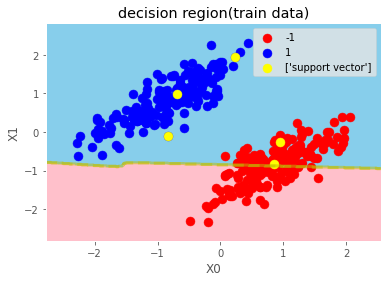

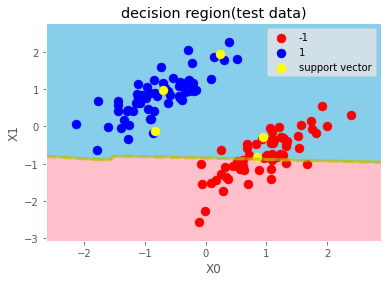

In [25]:
# 決定領域を描画（学習データ）
X_sv = pipeline_poly10["classifier"].X_sv
y_sv = pipeline_poly10["classifier"].y_sv
X_transformed = pipeline_poly10["scaler"].transform(X)
decision_region(X_transformed, y, model=pipeline_poly10["classifier"], step=0.01, title='decision region(train data)', xlabel=df_X.columns[0], ylabel=df_X.columns[1], target_names=[-1, 1], X1=X_sv, y1=y_sv, target_name1=["support vector"])
# 決定領域を描画（検証データ）
Xt_transformed = pipeline_poly10["scaler"].transform(Xt)
decision_region(Xt_transformed, yt, model=pipeline_poly10["classifier"], step=0.01, title='decision region(test data)', xlabel=df_X.columns[0], ylabel=df_X.columns[1], target_names=[-1,1], X1=X_sv, y1=y_sv, target_name1="support vector")

## 【DIVER 解説コピー】

決定境界とある点 $x$ との距離 $r$ は以下の式で求められます。高校数学で学ぶ「点と直線の距離の公式」や「点と平面の距離の公式」を一般化したものです。


r
=
y
i
y
(
x
)
|
|
w
|
|
=
y
i
w
T
x
|
|
w
|
|

$||w||$ はベクトル $w$ の大きさで、特徴量が2つならば $||w|| = \sqrt{w_{1}^2+w_{2}^2}$ です。また、学習するi番目のデータのラベルを $y_{i}=-1$または$y_{i}=1$ としています。


訓練データの中で「最も距離 $r$ が短くなる点x（サポートベクター）の距離 $r$ を最大化する $w$ を求める」ことがSVMによる分類だと言い換えられます。


これは非常に複雑な問題です。 $w$ を変化させると、最も距離 $r$ が短くなる点x（サポートベクター）も変化していくからです。計算するためには、問題を扱いやすい形に変形させる必要があります。

### ●扱いやすい形にする
まず定数 $M(>0)$ を置くと、先ほどの問題は、


「$\frac{M}{||w||}$ を $y_{i}(w^{T}x_{i})\geq M$ という条件の元で最大化する $w$ や $M$ を求める問題」


と表現できます。条件式は $x_{i}$ に訓練データのすべての点を入れて成り立つ必要があります。まだまだややこしいですが、これをMで割ってしまいます。そうすると、


「$\frac{1}{||w||}$ を $y_{i}(\frac{w^{T}}{M}x_{i})\geq 1$ という条件の元で最大化する $w$ や $M$ を求める問題」


になり、さらに $w^{T} \gets \frac{w^{T}}{M}$ と置き換えてしまいます。


そうすれば、


「 $\frac{1}{||w||}$ を $y_{i}(w^{T}X_{i})\geq 1$ という条件の元で最大化する $w$を求める問題」


まで簡単化できます。 $\frac{1}{||w||}$ を最大化するというのは $||w||$ を最小化することと同じです。これを後々さらに扱いやすくするために $\frac{1}{2}||w||^2$ を最小化すると考えます。よって、


「 $\frac{1}{2}||w||^2$ を $y_{i}(w^{T}x_{i})\geq 1$ という条件の元で最小化する $w$ を求める問題」


とすることができます。

### a

 解きやすい問題にする（双対化）
こういった不等式制約を持つ最適化問題は次のように ラグランジュの未定乗数法 で置き換えられることが知られています。


なお、このように難しい問題を別の簡単な問題に言い換えることを 双対化する といいます。


ラグランジュの未定乗数法を用いると以下のラグランジュ関数が得られます。


L
(
w
,
λ
)
=
1
2
|
|
w
|
|
2
−
N
∑
i
=
1
 
λ
i
{
y
i
(
w
T
x
i
)
−
1
}

$\lambda$ はラグランジュ乗数と呼ばれる数で、0以上の値です。これを $w$について微分し、0に等しいと置くと、次の式が得られます。


w
=
N
∑
i
=
1
 
λ
i
y
i
x
i

（この微分のために $||w||$ ではなく $\frac{1}{2}||w||^2$ としています）


これをラグランジュ関数に代入して整理すると


N
∑
i
=
1
 
λ
i
−
1
2
N
∑
i
=
1
  
N
∑
j
=
1
 
λ
i
λ
j
ｙ
i
ｙ
j
x
T
i
x
j

を $\lambda_{i} \geq 0$ かつ $\sum_{n=1}^{N}\lambda_{i}y_{i} = 0$ の条件の元で最大化するときの $\lambda_{i}$ を探す問題に双対化できます。


この形になれば、$\lambda$ を勾配降下法により求めることができます。$w$は出てきませんが、得られる結果は同じです。

### ●カーネル
最後の式の $x_{i}^{T} x_j$ の部分を $k(x_i, x_j)$ という関数に置き換えます。この関数を カーネル関数 と呼びます。


N
∑
i
=
1
 
λ
i
−
1
2
N
∑
i
=
1
  
N
∑
j
=
1
 
λ
i
λ
j
ｙ
i
ｙ
j
k
(
x
i
,
x
j
)

この式が問題1の最急降下法の式の元になります。


カーネル関数は $x_{i}^{T} x_j$ ではないさまざまな計算に置き換えることができます。この部分を置き換えるだけで、元の特徴量を 高次元空間 に移動させたことと同じ結果が得られ、高い分類性能を得ることができます。これを カーネルトリック と呼びます。

